## Import packages

In [43]:
# Import all the required packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc, roc_curve
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from tensorflow.keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from keras import regularizers 

In [1]:
# Open drive if needed
# from google.colab import drive
# drive.mount('/content/drive')

## Downloading and Saving Dataset

In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_dir = '/Users/chris_1/Deep Learning/assignment/lung_colon_image_set'
filepaths = []
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])
# Replace the path and save the dataset
np.save("/Users/chris_1/Deep Learning/assignment/data120.npy",image_matrix)
np.save("/Users/chris_1/Deep Learning/assignment/labels120.npy",tr_labels)

In [17]:
#  Replace the path and get the datatset
file_dir = "/Users/chris_1/Deep Learning/assignment/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)

# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [18]:
# Set LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical labels
y_encoded = label_encoder.fit_transform(labels)

# Now y_encoded contains numerical lables representing the classes
print(y_encoded)

# Transform with one-hot encoding
y_one_hot = to_categorical(y_encoded)
print(y_one_hot)

[4 4 4 ... 1 1 1]

[[0. 0. 0. 0. 1.]

 [0. 0. 0. 0. 1.]

 [0. 0. 0. 0. 1.]

 ...

 [0. 1. 0. 0. 0.]

 [0. 1. 0. 0. 0.]

 [0. 1. 0. 0. 0.]]


In [16]:
# Get the original names of labels
original_labels = label_encoder.inverse_transform(y_encoded)

# Create a dictionary to store correspondence between name and label, and store variables
name_label_mapping = dict(zip(y_encoded, original_labels))
classname = [str(i) for i in np.unique(y_encoded).tolist()] # ['0', '1', '2', '3', '4']
label_name = [name_label_mapping[i] for i in range(len(classname))] # ['Colon Benign Tissue','Colon adenocarcinoma','Lung Benign Tissue','Lung Squamous Cell Carcinoma','Lung adenocarcinoma']

## Visualizing Sample Images

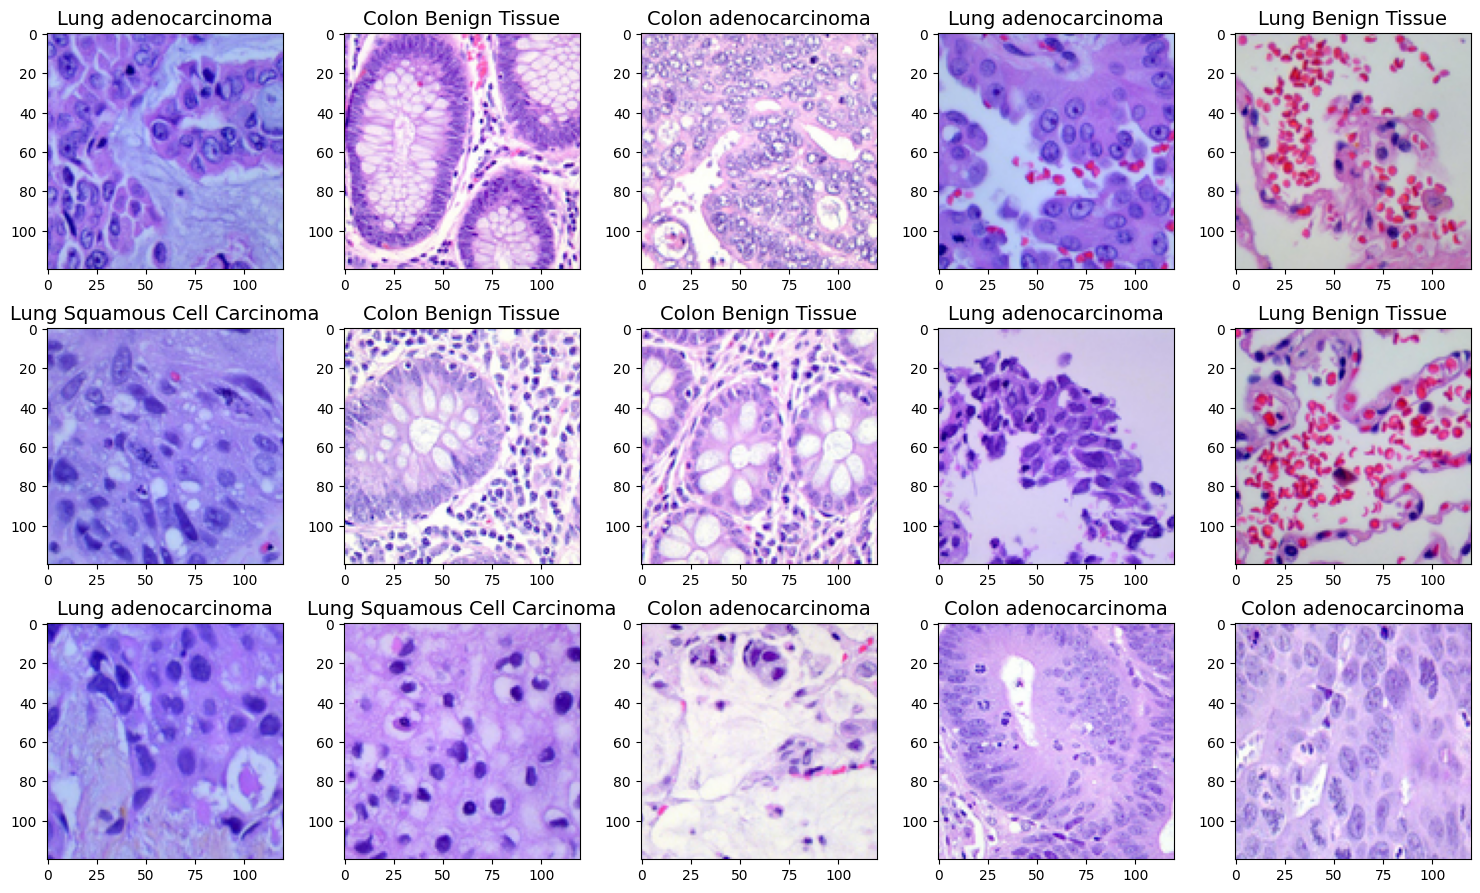

In [22]:
# Set up random numbers
random_numbers = [random.randint(1, len(y_encoded)) for i in range(15)]

# Print the grpah based on the random number and corresponding lables
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows, 5 columns

for i, index in enumerate(random_numbers):
    if i >= 15:  # Break the loop if we've plotted 15 images
        break
    # plot raw pixel data
    axes[i // 5, i % 5].imshow(data[index], cmap=plt.get_cmap('gray'))
    axes[i // 5, i % 5].set_title(labels[index], fontsize=14)

# Adjust layout
plt.tight_layout()

## Visualizing Class Distribution

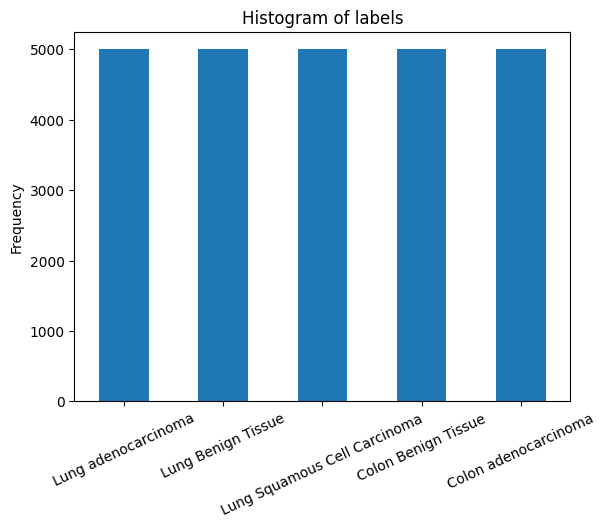

In [23]:
# Convert data to a pandas Series
series = pd.Series(labels)

# Get the value counts
value_counts = series.value_counts()

# Plot histogram
value_counts.plot(kind='bar')

# Add labels and title
plt.xticks(rotation=25)
plt.ylabel('Frequency')
plt.title('Histogram of labels')

# Show plot
plt.show()

##Train-Test-Val Split

In [24]:
# Split data with 60% training data and 40% testing data
X_train, X_temp, y_train, y_temp = train_test_split(data, y_one_hot, stratify=y_one_hot, test_size=0.4, random_state=42)

# Split testing data with 50% validation data and 50% testing data, which equals 20% validation and 20% test sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, stratify=y_temp,test_size=0.5, random_state=42)

# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [44]:
# LOSS-ACC GRAPHS
def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()
    
def loss_and_accuracy_summary(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plot_history([loss,val_loss],['Training loss','Validation loss'],title='Training and validation loss',ylabel='Loss')
    plot_history([acc,val_acc],['Training acc','Validation acc'],title='Training and validation accuracy',ylabel='Accuracy')
# Reference: plot_history comes from the notebooks - practical 3 

In [45]:
# Conf matrix and Classification Report
def confmatrix_and_classreport(X,y,classname,model):
    y_pred = model.predict(X)
    y_pred = (y_pred > 0.5)
    cm = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classname, yticklabels=label_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    accuracy = accuracy_score(y, y_pred)
    print('accuracy',accuracy)
    cr = classification_report(y, y_pred, target_names=classname)
    print(cr)

In [46]:
# ROC curves
def roc_curve(classname, X, y, model):
    y_score = model.predict(X)
    n_classes = len(np.unique(classname))
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the chance level line
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance Level')

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "limegreen", "purple"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {classname[class_id]}",
            color=color,
            ax=ax
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Receiver Operating Characteristic of Multiclass",
    )
# Reference: Sckit learn (https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

# Baseline Model

#### Modeling

In [31]:
# Create a sequential model
model = Sequential()

# Add convolutional,pooling,flatten, and dense layers
model.add(layers.Conv2D(128, (3, 3), activation='relu' ,padding='same',input_shape = X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      

                                                                 

 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         

 g2D)                                                            

                                                                 

 conv2d_3 (Conv2D)           (None, 60, 60, 64)        73792     

                                                                 

 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         

 g2D)                                                            

                                                                 

 flatten_1 (Flatten)         (None, 57600)             0         

                                                                 

 dense_3 (Dense)             (None, 12

In [32]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:{},Test Accuracy:{}'.format(test_loss,test_acc))

Epoch 1/10

469/469 [==============================] - 16s 32ms/step - loss: 7.3796 - accuracy: 0.4485 - val_loss: 0.9407 - val_accuracy: 0.5318

Epoch 2/10

469/469 [==============================] - 14s 31ms/step - loss: 0.7019 - accuracy: 0.6567 - val_loss: 0.6428 - val_accuracy: 0.6912

Epoch 3/10

469/469 [==============================] - 14s 31ms/step - loss: 0.6306 - accuracy: 0.6885 - val_loss: 0.7418 - val_accuracy: 0.7080

Epoch 4/10

469/469 [==============================] - 14s 31ms/step - loss: 0.6333 - accuracy: 0.7004 - val_loss: 0.6867 - val_accuracy: 0.7062

Epoch 5/10

469/469 [==============================] - 14s 31ms/step - loss: 0.5778 - accuracy: 0.7205 - val_loss: 0.5964 - val_accuracy: 0.7358

Epoch 6/10

469/469 [==============================] - 14s 31ms/step - loss: 0.5145 - accuracy: 0.7463 - val_loss: 0.9325 - val_accuracy: 0.6196

Epoch 7/10

469/469 [==============================] - 14s 31ms/step - loss: 0.4928 - accuracy: 0.7665 - val_loss: 0.6658 - 

#### Training and validation losses and accuracies

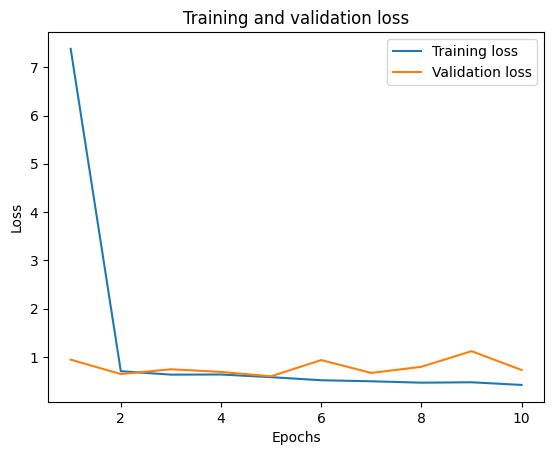

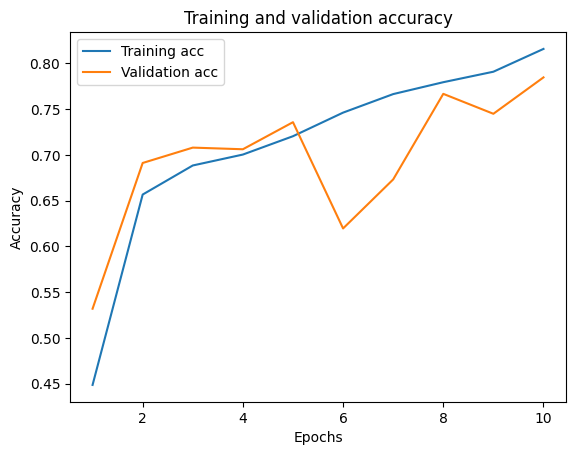

In [33]:
loss_and_accuracy_summary(history)

#### ROC curve with the Area under the Curve (AUC) score and a confusion matrix on testing set

157/157 [==============================] - 1s 7ms/step


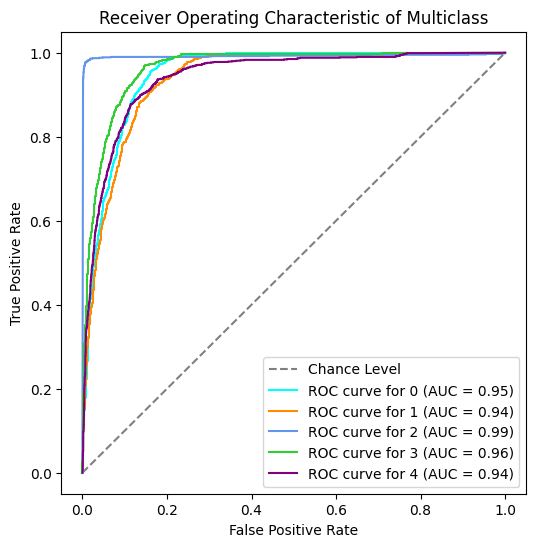

In [34]:
roc_curve(classname, X_test, y_test,model)

157/157 [==============================] - 1s 7ms/step


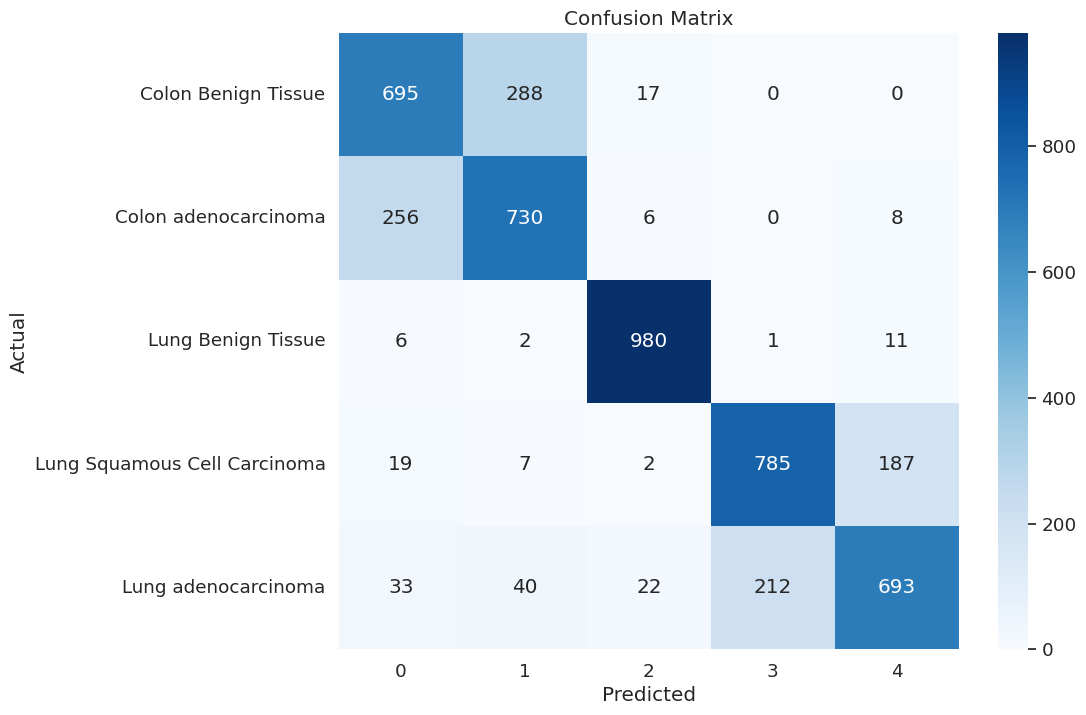

accuracy 0.7738

              precision    recall  f1-score   support



           0       0.73      0.68      0.71      1000

           1       0.68      0.73      0.71      1000

           2       0.95      0.98      0.97      1000

           3       0.79      0.79      0.79      1000

           4       0.77      0.69      0.73      1000



   micro avg       0.79      0.77      0.78      5000

   macro avg       0.79      0.77      0.78      5000

weighted avg       0.79      0.77      0.78      5000

 samples avg       0.77      0.77      0.77      5000




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
confmatrix_and_classreport(X_test,y_test,classname,model)

#### ROC curve with the Area under the Curve (AUC) score and a confusion matrix on validation set

157/157 [==============================] - 1s 7ms/step


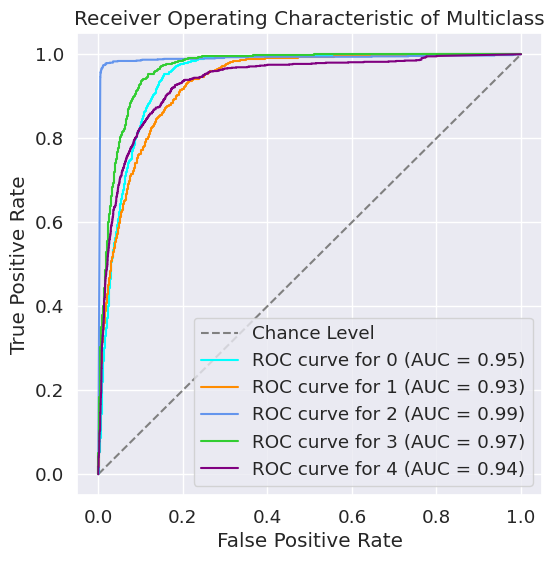

In [36]:
roc_curve(classname, X_val, y_val,model)

157/157 [==============================] - 1s 7ms/step


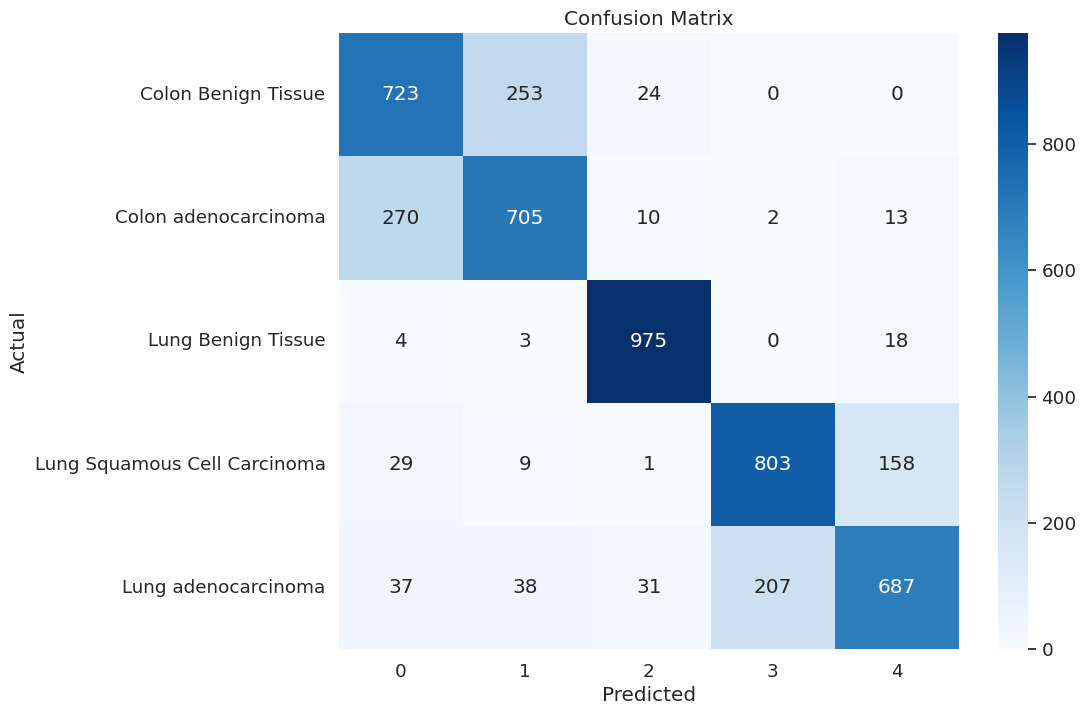

accuracy 0.7764

              precision    recall  f1-score   support



           0       0.73      0.71      0.72      1000

           1       0.70      0.70      0.70      1000

           2       0.94      0.97      0.96      1000

           3       0.79      0.80      0.80      1000

           4       0.78      0.69      0.73      1000



   micro avg       0.79      0.78      0.78      5000

   macro avg       0.79      0.78      0.78      5000

weighted avg       0.79      0.78      0.78      5000

 samples avg       0.78      0.78      0.78      5000




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
confmatrix_and_classreport(X_val,y_val,classname,model)

# Enhanced Model

### Preprcessing
1. Denoise with Gaussian Blur
2. Resize images to 64x64x3

In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_dir = '/Users/chris_1/Deep Learning/assignment/lung_colon_image_set'
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((64,64), Image.LANCZOS)
                  # Append image and label to respective lists
                  im_array = np.array(im)
                  # Apply Gaussian blur for denoising
                  denoised_im_array = cv2.GaussianBlur(im_array, (3,3), 90, 90)
                  # Append denoised image to image_data list
                  image_data.append(denoised_im_array)
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/Users/chris_1/Deep Learning/assignment/data64_de.npy",image_matrix)
np.save("/Users/chris_1/Deep Learning/assignment/labels64_de.npy",tr_labels)

In [47]:
# Change your path accordingly and use the processed data
file_dir = "/Users/chris_1/Deep Learning/assignment/"
data = np.load(file_dir + "data64_de.npy")
labels = np.load(file_dir + "labels64_de.npy", allow_pickle=True)

In [48]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical labels
y_encoded = label_encoder.fit_transform(labels)

# Now y_encoded contains numerical indices representing the classes
print(y_encoded)

# Convert to one-hot encoding
y_one_hot = to_categorical(y_encoded)
print(y_one_hot)

[4 4 4 ... 1 1 1]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


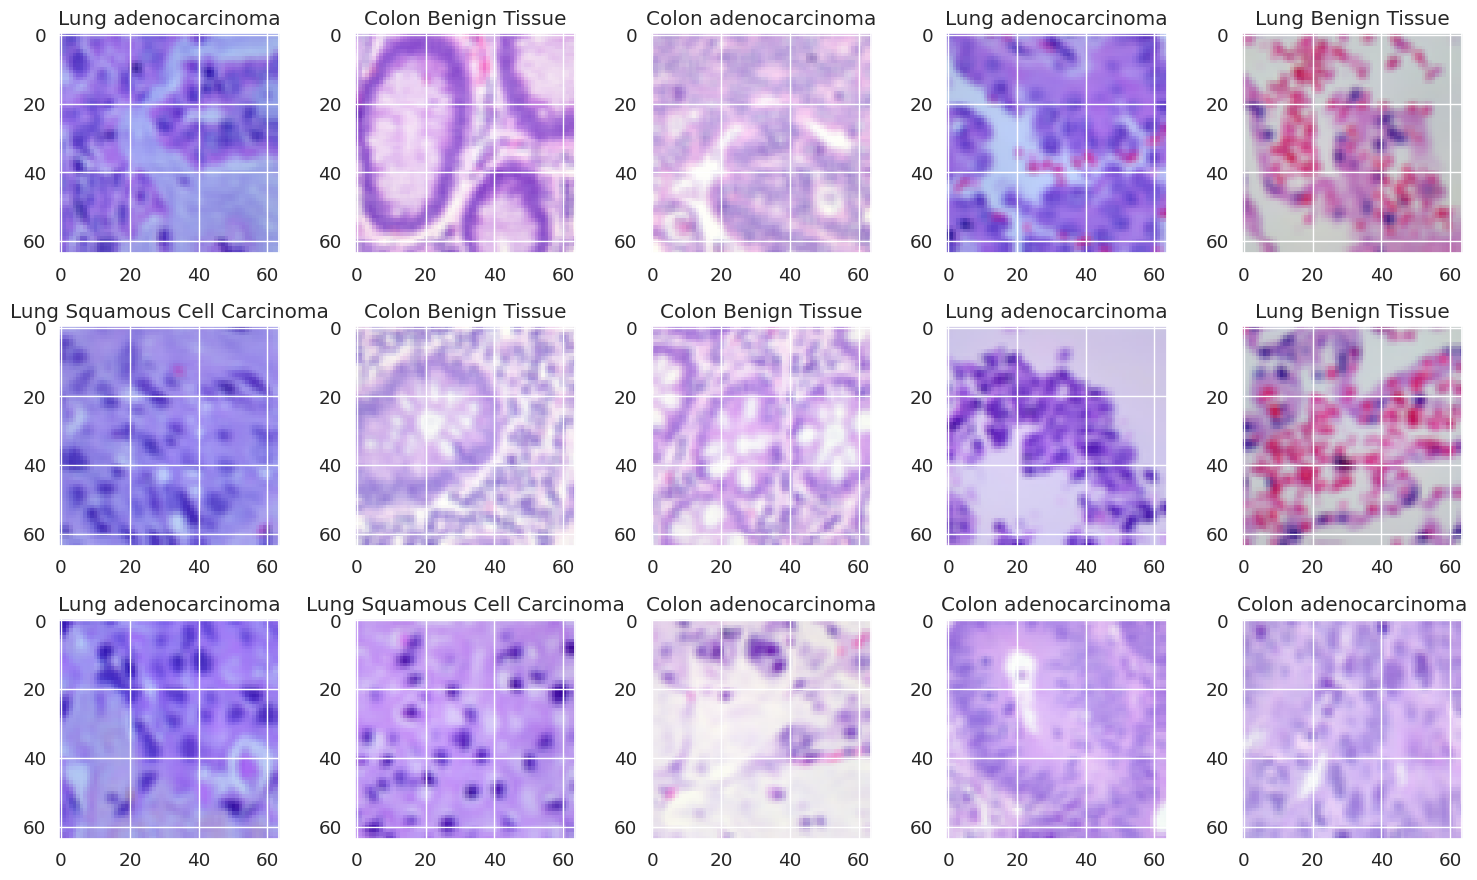

In [41]:
# Print the grpah based on the random number and corresponding lables
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows, 5 columns

for i, index in enumerate(random_numbers):
    if i >= 15:  # Break the loop if we've plotted 15 images
        break
    # plot raw pixel data
    axes[i // 5, i % 5].imshow(data[index], cmap=plt.get_cmap('gray'))
    axes[i // 5, i % 5].set_title(labels[index])

# Adjust layout
plt.tight_layout()

In [49]:
# Split data with 60% training data and 40% testing data
X_train, X_temp, y_train, y_temp = train_test_split(data, y_one_hot, stratify=y_one_hot, test_size=0.4, random_state=42)

# Split testing data with 50% validation data and 50% testing data, which equals 20% validation and 20% test sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, stratify=y_temp,test_size=0.5, random_state=42)

In [43]:
# Create a sequential model
model = Sequential()

# Add convolutional, pooling, flatten, and dense layers
model.add(layers.Conv2D(128, (3, 3), activation='relu' ,padding='same',input_shape = X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_4"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_4 (Conv2D)           (None, 64, 64, 128)       3584      

                                                                 

 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 128)       0         

 g2D)                                                            

                                                                 

 conv2d_5 (Conv2D)           (None, 32, 32, 64)        73792     

                                                                 

 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         

 g2D)                                                            

                                                                 

 flatten_2 (Flatten)         (None, 16384)             0         

                                                                 

 dense_6 (Dense)             (None, 12

In [44]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10

469/469 [==============================] - 8s 12ms/step - loss: 1.6403 - accuracy: 0.5387 - val_loss: 0.8526 - val_accuracy: 0.6044

Epoch 2/10

469/469 [==============================] - 5s 10ms/step - loss: 0.6539 - accuracy: 0.6879 - val_loss: 0.5892 - val_accuracy: 0.7350

Epoch 3/10

469/469 [==============================] - 5s 11ms/step - loss: 0.5952 - accuracy: 0.7283 - val_loss: 0.5320 - val_accuracy: 0.7514

Epoch 4/10

469/469 [==============================] - 5s 10ms/step - loss: 0.4611 - accuracy: 0.7909 - val_loss: 0.5113 - val_accuracy: 0.7798

Epoch 5/10

469/469 [==============================] - 5s 10ms/step - loss: 0.4181 - accuracy: 0.8133 - val_loss: 0.4767 - val_accuracy: 0.7854

Epoch 6/10

469/469 [==============================] - 5s 10ms/step - loss: 0.3857 - accuracy: 0.8279 - val_loss: 0.4050 - val_accuracy: 0.8290

Epoch 7/10

469/469 [==============================] - 5s 10ms/step - loss: 0.3652 - accuracy: 0.8389 - val_loss: 0.4366 - val_acc

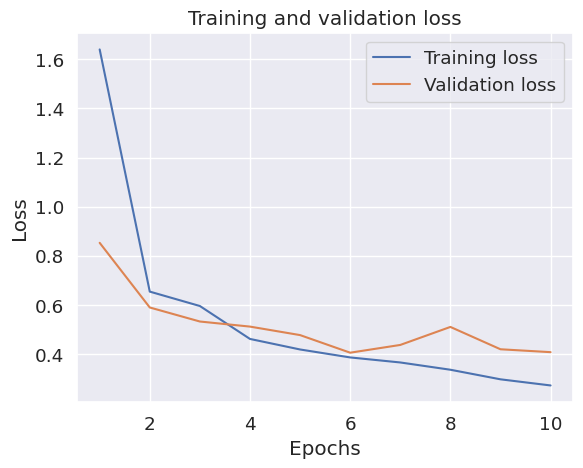

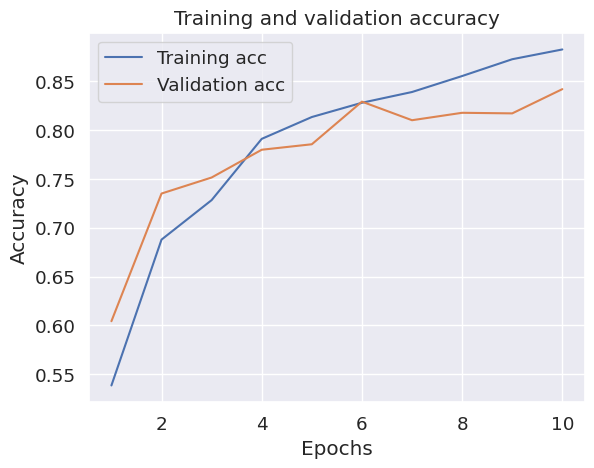

In [45]:
loss_and_accuracy_summary(history)

In [46]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)
accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 0s 3ms/step


0.8386

### Change number of layers and neurons

In [96]:
# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu' ,input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_15"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_36 (Conv2D)          (None, 62, 62, 32)        896       

                                                                 

 conv2d_37 (Conv2D)          (None, 60, 60, 64)        18496     

                                                                 

 max_pooling2d_26 (MaxPooli  (None, 30, 30, 64)        0         

 ng2D)                                                           

                                                                 

 conv2d_38 (Conv2D)          (None, 28, 28, 128)       73856     

                                                                 

 max_pooling2d_27 (MaxPooli  (None, 14, 14, 128)       0         

 ng2D)                                                           

                                                                 

 flatten_13 (Flatten)        (None, 2

In [97]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10

469/469 [==============================] - 8s 14ms/step - loss: 2.4519 - accuracy: 0.6221 - val_loss: 0.7754 - val_accuracy: 0.6998

Epoch 2/10

469/469 [==============================] - 6s 13ms/step - loss: 0.4600 - accuracy: 0.8064 - val_loss: 0.3742 - val_accuracy: 0.8440

Epoch 3/10

469/469 [==============================] - 6s 13ms/step - loss: 0.3298 - accuracy: 0.8641 - val_loss: 0.2983 - val_accuracy: 0.8838

Epoch 4/10

469/469 [==============================] - 6s 13ms/step - loss: 0.2542 - accuracy: 0.9007 - val_loss: 0.2744 - val_accuracy: 0.8916

Epoch 5/10

469/469 [==============================] - 6s 13ms/step - loss: 0.1792 - accuracy: 0.9305 - val_loss: 0.3057 - val_accuracy: 0.8946

Epoch 6/10

469/469 [==============================] - 6s 13ms/step - loss: 0.1707 - accuracy: 0.9321 - val_loss: 0.3065 - val_accuracy: 0.8942

Epoch 7/10

469/469 [==============================] - 6s 13ms/step - loss: 0.1543 - accuracy: 0.9461 - val_loss: 0.3675 - val_acc

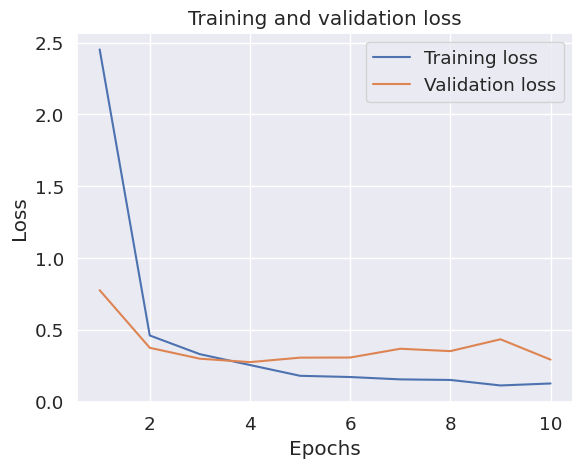

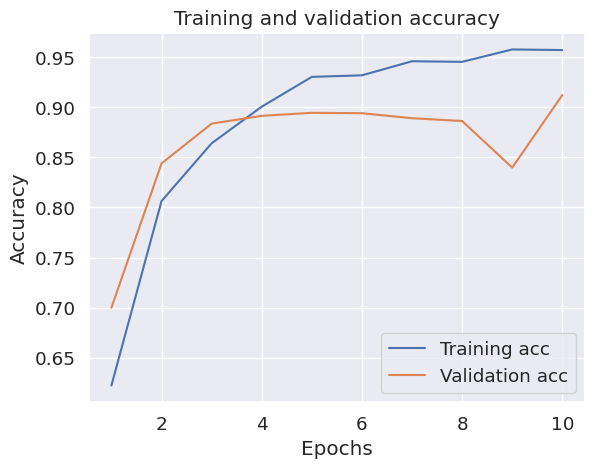

In [98]:
loss_and_accuracy_summary(history)

In [99]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)
accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 1s 4ms/step


0.9112

### Number of epochs

In [100]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50

469/469 [==============================] - 6s 13ms/step - loss: 0.0900 - accuracy: 0.9669 - val_loss: 0.3377 - val_accuracy: 0.9054

Epoch 2/50

469/469 [==============================] - 6s 13ms/step - loss: 0.0743 - accuracy: 0.9741 - val_loss: 0.6291 - val_accuracy: 0.8316

Epoch 3/50

469/469 [==============================] - 6s 13ms/step - loss: 0.0852 - accuracy: 0.9711 - val_loss: 0.3379 - val_accuracy: 0.9050

Epoch 4/50

469/469 [==============================] - 6s 13ms/step - loss: 0.1162 - accuracy: 0.9615 - val_loss: 0.3983 - val_accuracy: 0.9086

Epoch 5/50

469/469 [==============================] - 6s 13ms/step - loss: 0.0628 - accuracy: 0.9783 - val_loss: 0.4558 - val_accuracy: 0.8956

Epoch 6/50

469/469 [==============================] - 6s 13ms/step - loss: 0.0822 - accuracy: 0.9755 - val_loss: 0.5151 - val_accuracy: 0.8664

Epoch 7/50

469/469 [==============================] - 6s 13ms/step - loss: 0.0670 - accuracy: 0.9785 - val_loss: 0.5112 - val_acc

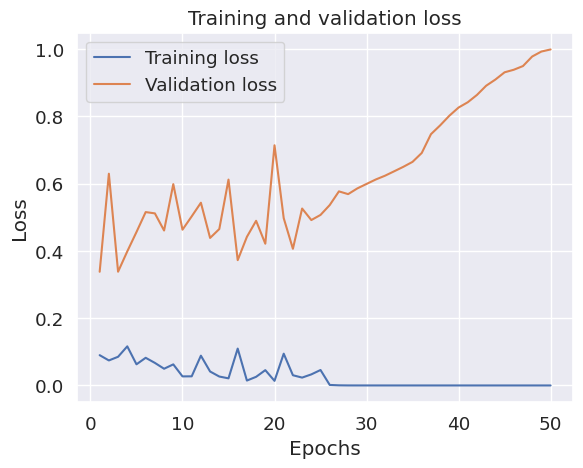

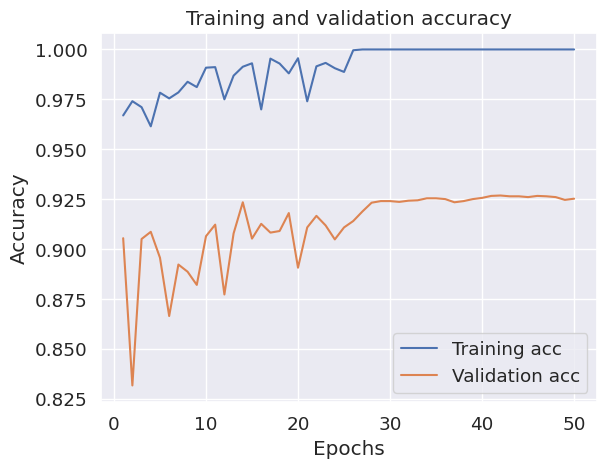

In [101]:
loss_and_accuracy_summary(history)

In [102]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)
accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 1s 3ms/step


0.9252

#### Dropout layer

In [104]:
# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu' ,input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_39 (Conv2D)          (None, 62, 62, 32)        896       

                                                                 

 conv2d_40 (Conv2D)          (None, 60, 60, 64)        18496     

                                                                 

 max_pooling2d_28 (MaxPooli  (None, 30, 30, 64)        0         

 ng2D)                                                           

                                                                 

 conv2d_41 (Conv2D)          (None, 28, 28, 128)       73856     

                                                                 

 max_pooling2d_29 (MaxPooli  (None, 14, 14, 128)       0         

 ng2D)                                                           

                                                                 

 dropout_15 (Dropout)        (None, 1

In [105]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50


2024-03-08 23:33:20.137532: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 10s 16ms/step - loss: 2.2347 - accuracy: 0.5333 - val_loss: 0.6875 - val_accuracy: 0.6026

Epoch 2/50

469/469 [==============================] - 7s 15ms/step - loss: 0.7454 - accuracy: 0.5991 - val_loss: 0.6429 - val_accuracy: 0.6240

Epoch 3/50

469/469 [==============================] - 7s 15ms/step - loss: 0.6799 - accuracy: 0.6209 - val_loss: 0.6216 - val_accuracy: 0.6472

Epoch 4/50

469/469 [==============================] - 7s 15ms/step - loss: 0.6789 - accuracy: 0.6269 - val_loss: 0.6241 - val_accuracy: 0.6382

Epoch 5/50

469/469 [==============================] - 7s 15ms/step - loss: 0.6417 - accuracy: 0.6575 - val_loss: 0.6229 - val_accuracy: 0.6496

Epoch 6/50

469/469 [==============================] - 7s 15ms/step - loss: 0.5635 - accuracy: 0.7260 - val_loss: 0.4707 - val_accuracy: 0.7844

Epoch 7/50

469/469 [==============================] - 7s 15ms/step - loss: 0.5450 - accuracy: 0.7511 - val_loss: 0.4827 - val_accuracy: 0.79

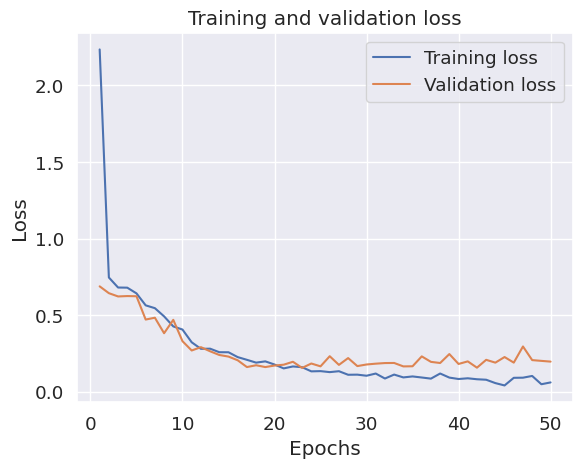

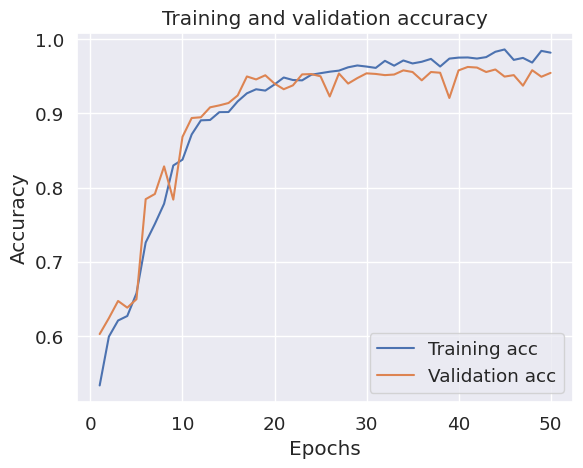

In [106]:
loss_and_accuracy_summary(history)

In [107]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)
accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 1s 3ms/step


0.9538

## Final model (Choose the optimal point for the number of epochs from the early stop above)

In [108]:
# 23rd is chosen as the optimal point
history = model.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/23

469/469 [==============================] - 7s 16ms/step - loss: 0.2080 - accuracy: 0.9321 - val_loss: 0.2150 - val_accuracy: 0.9428

Epoch 2/23

469/469 [==============================] - 7s 15ms/step - loss: 0.0575 - accuracy: 0.9828 - val_loss: 0.1924 - val_accuracy: 0.9610

Epoch 3/23

469/469 [==============================] - 7s 15ms/step - loss: 0.0415 - accuracy: 0.9869 - val_loss: 0.2388 - val_accuracy: 0.9554

Epoch 4/23

469/469 [==============================] - 7s 15ms/step - loss: 0.0678 - accuracy: 0.9804 - val_loss: 0.2443 - val_accuracy: 0.9514

Epoch 5/23

469/469 [==============================] - 7s 15ms/step - loss: 0.0783 - accuracy: 0.9758 - val_loss: 0.4190 - val_accuracy: 0.9234

Epoch 6/23

469/469 [==============================] - 7s 15ms/step - loss: 0.0652 - accuracy: 0.9843 - val_loss: 0.2808 - val_accuracy: 0.9208

Epoch 7/23

469/469 [==============================] - 7s 15ms/step - loss: 0.0803 - accuracy: 0.9765 - val_loss: 0.5329 - val_acc

In [109]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 0s 3ms/step


0.9598

157/157 [==============================] - 1s 3ms/step


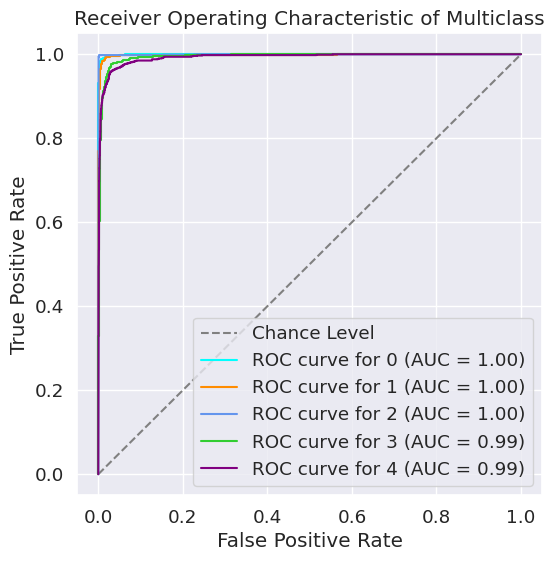

In [110]:
roc_curve(classname, X_test, y_test,model)

157/157 [==============================] - 0s 3ms/step


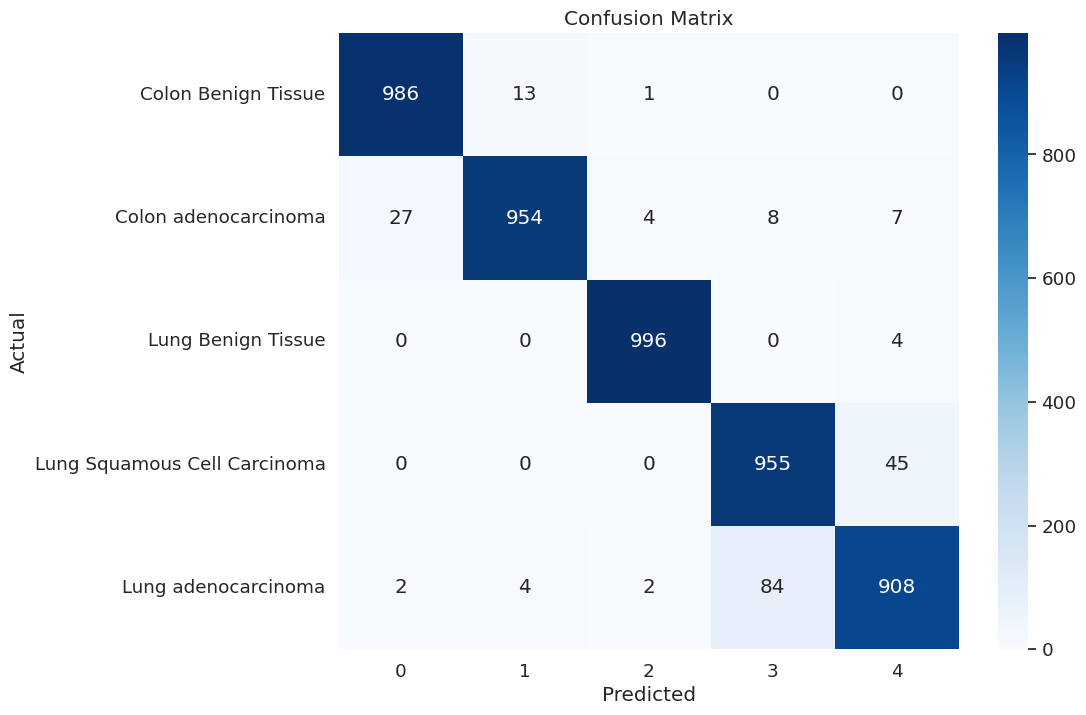

accuracy 0.9598

              precision    recall  f1-score   support



           0       0.97      0.99      0.98      1000

           1       0.98      0.95      0.97      1000

           2       0.99      1.00      0.99      1000

           3       0.91      0.95      0.93      1000

           4       0.94      0.91      0.92      1000



   micro avg       0.96      0.96      0.96      5000

   macro avg       0.96      0.96      0.96      5000

weighted avg       0.96      0.96      0.96      5000

 samples avg       0.96      0.96      0.96      5000




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
confmatrix_and_classreport(X_test,y_test,classname,model)

### Extended experiment

#### Optimizer
RMSprop

In [160]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/23


2024-03-09 00:51:27.039207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 [==============================] - 9s 16ms/step - loss: 0.6451 - accuracy: 0.8923 - val_loss: 0.3300 - val_accuracy: 0.9346

Epoch 2/23

469/469 [==============================] - 7s 15ms/step - loss: 0.4903 - accuracy: 0.9008 - val_loss: 0.3018 - val_accuracy: 0.9584

Epoch 3/23

469/469 [==============================] - 7s 15ms/step - loss: 0.4998 - accuracy: 0.9025 - val_loss: 0.4829 - val_accuracy: 0.8410

Epoch 4/23

469/469 [==============================] - 7s 15ms/step - loss: 0.4932 - accuracy: 0.9005 - val_loss: 0.2919 - val_accuracy: 0.9336

Epoch 5/23

469/469 [==============================] - 7s 15ms/step - loss: 0.4984 - accuracy: 0.8921 - val_loss: 0.3751 - val_accuracy: 0.9090

Epoch 6/23

469/469 [==============================] - 7s 15ms/step - loss: 0.5137 - accuracy: 0.9007 - val_loss: 0.2457 - val_accuracy: 0.9498

Epoch 7/23

469/469 [==============================] - 7s 15ms/step - loss: 0.5463 - accuracy: 0.8917 - val_loss: 0.6734 - val_accuracy: 0.903

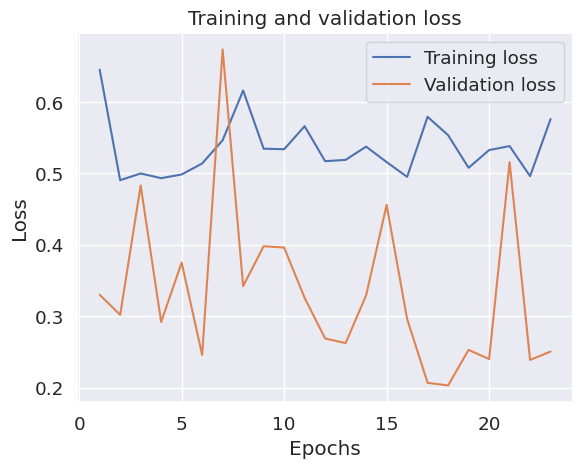

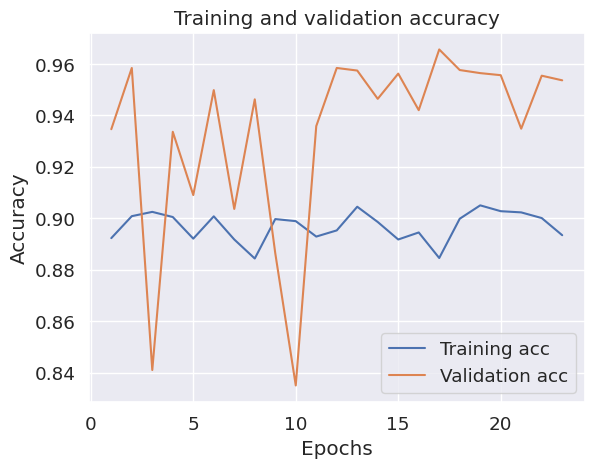

In [161]:
loss_and_accuracy_summary(history)

#### Activation function

##### Sigmoid

In [50]:
# Create a sequential model
model2 = Sequential()

# Add convolutional and pooling layers
model2.add(layers.Conv2D(32, (3, 3), activation='sigmoid' ,input_shape = X_train.shape[1:]))
model2.add(layers.Conv2D(64, (3, 3), activation='sigmoid'))
model2.add(layers.MaxPooling2D(strides=(2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='sigmoid'))
model2.add(layers.MaxPooling2D(strides=(2, 2)))
model2.add(Dropout(0.4))
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='sigmoid'))
model2.add(Dropout(0.4))
model2.add(layers.Dense(64, activation='sigmoid'))
model2.add(Dropout(0.4))
model2.add(layers.Dense(5, activation='softmax'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 128)      

In [117]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/23

469/469 [==============================] - 10s 18ms/step - loss: 1.6378 - accuracy: 0.1989 - val_loss: 1.6100 - val_accuracy: 0.2000

Epoch 2/23

469/469 [==============================] - 8s 17ms/step - loss: 1.6123 - accuracy: 0.1996 - val_loss: 1.6102 - val_accuracy: 0.2000

Epoch 3/23

469/469 [==============================] - 8s 17ms/step - loss: 1.6113 - accuracy: 0.1966 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 4/23

469/469 [==============================] - 8s 17ms/step - loss: 1.6101 - accuracy: 0.1952 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 5/23

469/469 [==============================] - 8s 17ms/step - loss: 1.6101 - accuracy: 0.1981 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 6/23

469/469 [==============================] - 8s 17ms/step - loss: 1.6101 - accuracy: 0.1995 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 7/23

469/469 [==============================] - 8s 17ms/step - loss: 1.6099 - accuracy: 0.2023 - val_loss: 1.6096 - val_ac

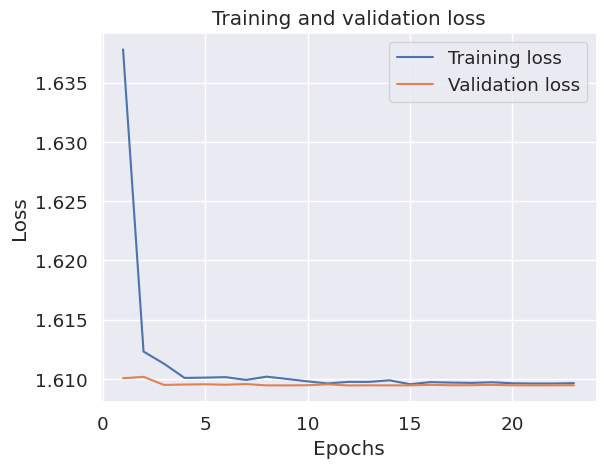

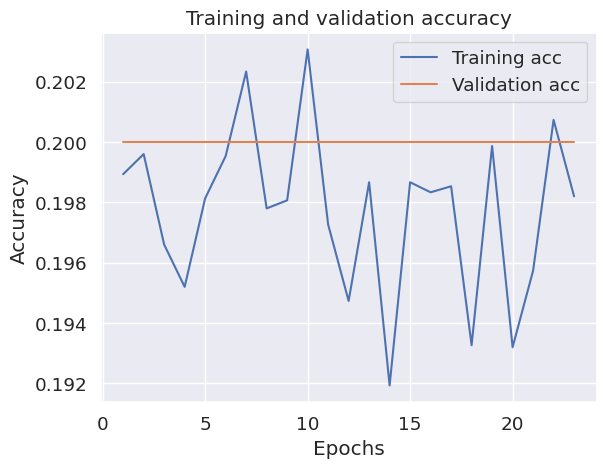

In [118]:
loss_and_accuracy_summary(history2)

##### tangent

In [123]:
# Create a sequential model
model2 = Sequential()

# Add convolutional and pooling layers
model2.add(layers.Conv2D(32, (3, 3), activation='tanh' ,input_shape = X_train.shape[1:]))
model2.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model2.add(layers.MaxPooling2D(strides=(2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='tanh'))
model2.add(layers.MaxPooling2D(strides=(2, 2)))
model2.add(Dropout(0.4))
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='tanh'))
model2.add(Dropout(0.4))
model2.add(layers.Dense(64, activation='tanh'))
model2.add(Dropout(0.4))
model2.add(layers.Dense(5, activation='softmax'))

model2.summary()

Model: "sequential_21"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_54 (Conv2D)          (None, 62, 62, 32)        896       

                                                                 

 conv2d_55 (Conv2D)          (None, 60, 60, 64)        18496     

                                                                 

 max_pooling2d_38 (MaxPooli  (None, 30, 30, 64)        0         

 ng2D)                                                           

                                                                 

 conv2d_56 (Conv2D)          (None, 28, 28, 128)       73856     

                                                                 

 max_pooling2d_39 (MaxPooli  (None, 14, 14, 128)       0         

 ng2D)                                                           

                                                                 

 dropout_30 (Dropout)        (None, 1

In [128]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/23

469/469 [==============================] - 10s 18ms/step - loss: 0.6112 - accuracy: 0.7661 - val_loss: 0.6197 - val_accuracy: 0.7590

Epoch 2/23

469/469 [==============================] - 8s 17ms/step - loss: 0.6098 - accuracy: 0.7725 - val_loss: 0.4553 - val_accuracy: 0.8408

Epoch 3/23

469/469 [==============================] - 8s 17ms/step - loss: 0.6029 - accuracy: 0.7773 - val_loss: 0.5325 - val_accuracy: 0.7990

Epoch 4/23

469/469 [==============================] - 8s 17ms/step - loss: 0.5919 - accuracy: 0.7757 - val_loss: 1.3376 - val_accuracy: 0.5338

Epoch 5/23

469/469 [==============================] - 8s 17ms/step - loss: 0.5844 - accuracy: 0.7831 - val_loss: 0.5132 - val_accuracy: 0.8268

Epoch 6/23

469/469 [==============================] - 8s 17ms/step - loss: 0.5993 - accuracy: 0.7784 - val_loss: 0.6586 - val_accuracy: 0.7074

Epoch 7/23

469/469 [==============================] - 8s 17ms/step - loss: 0.5748 - accuracy: 0.7820 - val_loss: 0.4694 - val_ac

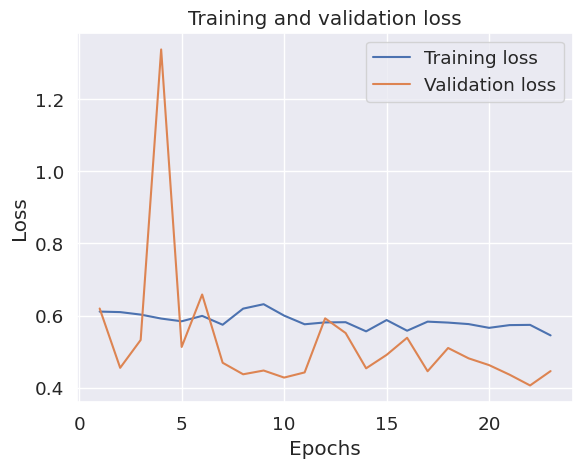

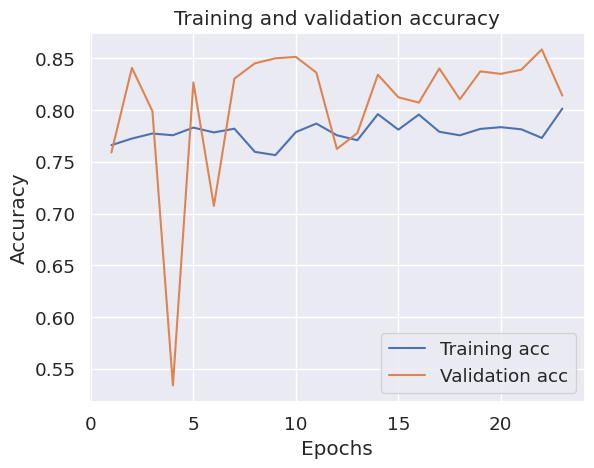

In [129]:
loss_and_accuracy_summary(history2)

#### Kernel Size

In [169]:
# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (11, 11), activation='relu' ,input_shape = X_train.shape[1:],strides=(4, 4), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_34"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_92 (Conv2D)          (None, 14, 14, 32)        11648     

                                                                 

 conv2d_93 (Conv2D)          (None, 12, 12, 64)        18496     

                                                                 

 max_pooling2d_62 (MaxPooli  (None, 6, 6, 64)          0         

 ng2D)                                                           

                                                                 

 conv2d_94 (Conv2D)          (None, 4, 4, 128)         73856     

                                                                 

 max_pooling2d_63 (MaxPooli  (None, 2, 2, 128)         0         

 ng2D)                                                           

                                                                 

 dropout_66 (Dropout)        (None, 2

In [170]:
# Choose appropriate optimizer, loss, and metrics for the goal and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/23

469/469 [==============================] - 4s 6ms/step - loss: 1.9022 - accuracy: 0.1997 - val_loss: 1.6096 - val_accuracy: 0.2000

Epoch 2/23

469/469 [==============================] - 2s 5ms/step - loss: 1.6099 - accuracy: 0.1994 - val_loss: 1.6096 - val_accuracy: 0.2000

Epoch 3/23

469/469 [==============================] - 2s 5ms/step - loss: 1.6099 - accuracy: 0.2024 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 4/23

469/469 [==============================] - 2s 5ms/step - loss: 1.6099 - accuracy: 0.1955 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 5/23

469/469 [==============================] - 2s 5ms/step - loss: 1.6098 - accuracy: 0.1931 - val_loss: 1.6095 - val_accuracy: 0.2000

Epoch 6/23

469/469 [==============================] - 3s 5ms/step - loss: 1.6098 - accuracy: 0.1975 - val_loss: 1.6096 - val_accuracy: 0.2000

Epoch 7/23

469/469 [==============================] - 2s 5ms/step - loss: 1.6098 - accuracy: 0.1963 - val_loss: 1.6095 - val_accuracy: 

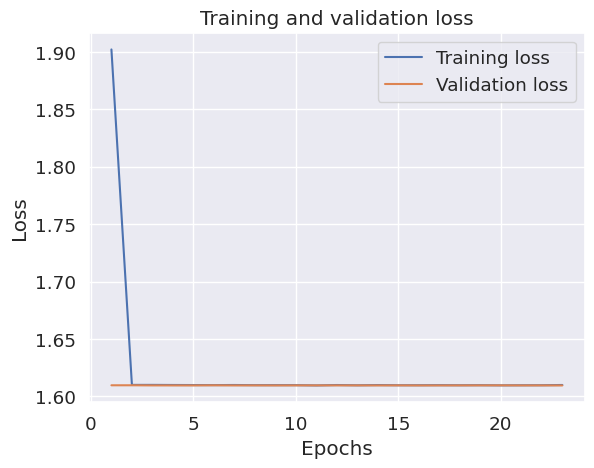

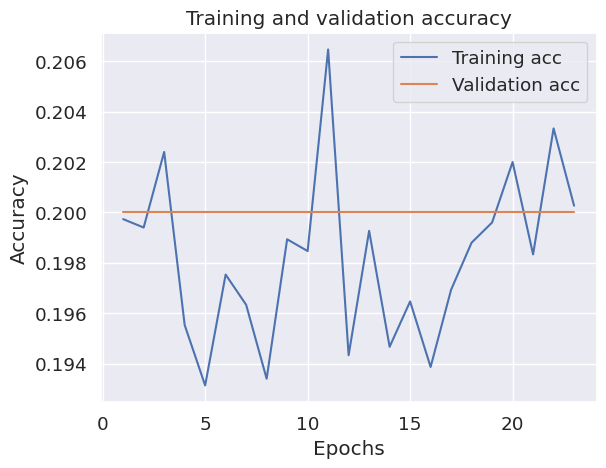

In [171]:
loss_and_accuracy_summary(history)

#### Regularization

In [51]:
# Define the regularization parameters
l2_param = 0.016
l1_bias_param = 0.006
l1_activity_param = 0.006

# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu' ,input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax',kernel_regularizer=regularizers.l2(l2_param), 
                bias_regularizer=regularizers.l1(l1_bias_param), 
                activity_regularizer=regularizers.l1(l1_activity_param)))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 25088)            

In [52]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=23, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/23
469/469 [==============================] - 9s 15ms/step - loss: 3.9997 - accuracy: 0.3454 - val_loss: 1.3202 - val_accuracy: 0.3926
Epoch 2/23
469/469 [==============================] - 6s 14ms/step - loss: 1.2814 - accuracy: 0.4272 - val_loss: 1.2745 - val_accuracy: 0.4308
Epoch 3/23
469/469 [==============================] - 6s 14ms/step - loss: 1.0534 - accuracy: 0.5747 - val_loss: 0.7399 - val_accuracy: 0.7354
Epoch 4/23
469/469 [==============================] - 6s 14ms/step - loss: 0.6368 - accuracy: 0.7650 - val_loss: 0.7133 - val_accuracy: 0.7718
Epoch 5/23
469/469 [==============================] - 6s 14ms/step - loss: 0.5062 - accuracy: 0.8315 - val_loss: 0.4969 - val_accuracy: 0.8372
Epoch 6/23
469/469 [==============================] - 6s 14ms/step - loss: 0.4145 - accuracy: 0.8673 - val_loss: 0.4602 - val_accuracy: 0.8444
Epoch 7/23
469/469 [==============================] - 7s 14ms/step - loss: 0.3759 - accuracy: 0.8839 - val_loss: 0.4331 - val_accuracy: 0.8650

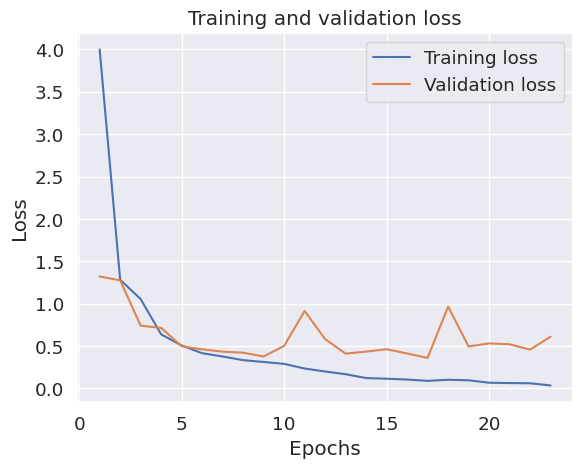

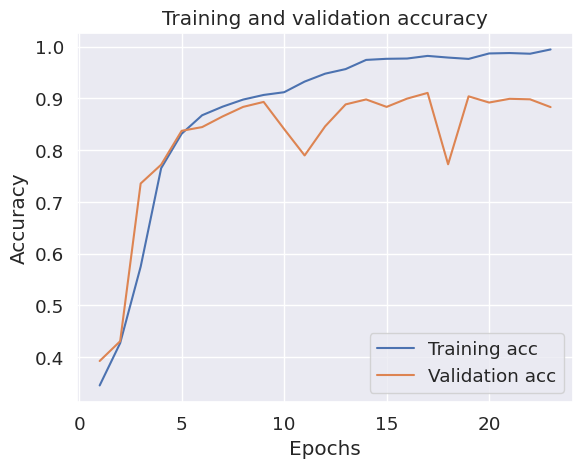

In [53]:
loss_and_accuracy_summary(history)

#### Final result (Choose the optimal point for the number of epochs from the early stop above)

In [54]:
history = model.fit(X_train, y_train, epochs=17, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/17
469/469 [==============================] - 7s 14ms/step - loss: 0.0458 - accuracy: 0.9911 - val_loss: 0.4697 - val_accuracy: 0.9072
Epoch 2/17
469/469 [==============================] - 6s 14ms/step - loss: 0.0425 - accuracy: 0.9907 - val_loss: 0.5182 - val_accuracy: 0.9030
Epoch 3/17
469/469 [==============================] - 6s 14ms/step - loss: 0.0554 - accuracy: 0.9887 - val_loss: 0.4985 - val_accuracy: 0.8736
Epoch 4/17
469/469 [==============================] - 6s 14ms/step - loss: 0.0586 - accuracy: 0.9875 - val_loss: 0.3871 - val_accuracy: 0.9106
Epoch 5/17
469/469 [==============================] - 7s 14ms/step - loss: 0.0581 - accuracy: 0.9851 - val_loss: 0.4342 - val_accuracy: 0.9104
Epoch 6/17
469/469 [==============================] - 7s 14ms/step - loss: 0.0261 - accuracy: 0.9961 - val_loss: 0.4846 - val_accuracy: 0.9160
Epoch 7/17
469/469 [==============================] - 7s 14ms/step - loss: 0.0133 - accuracy: 0.9995 - val_loss: 0.4773 - val_accuracy: 0.9192

157/157 [==============================] - 1s 3ms/step


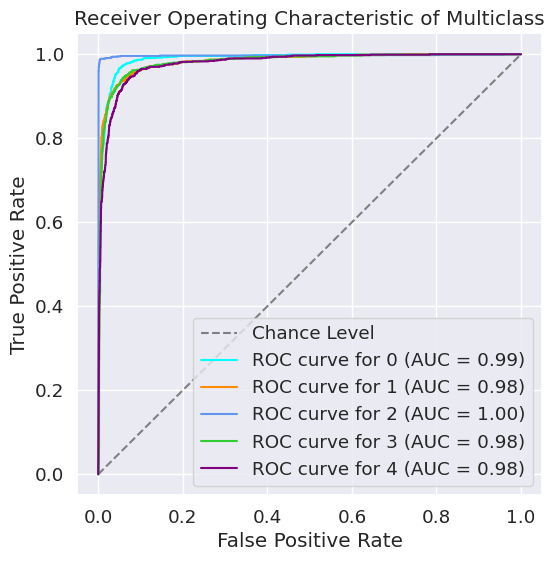

In [55]:
roc_curve(classname, X_test, y_test,model)

157/157 [==============================] - 1s 3ms/step


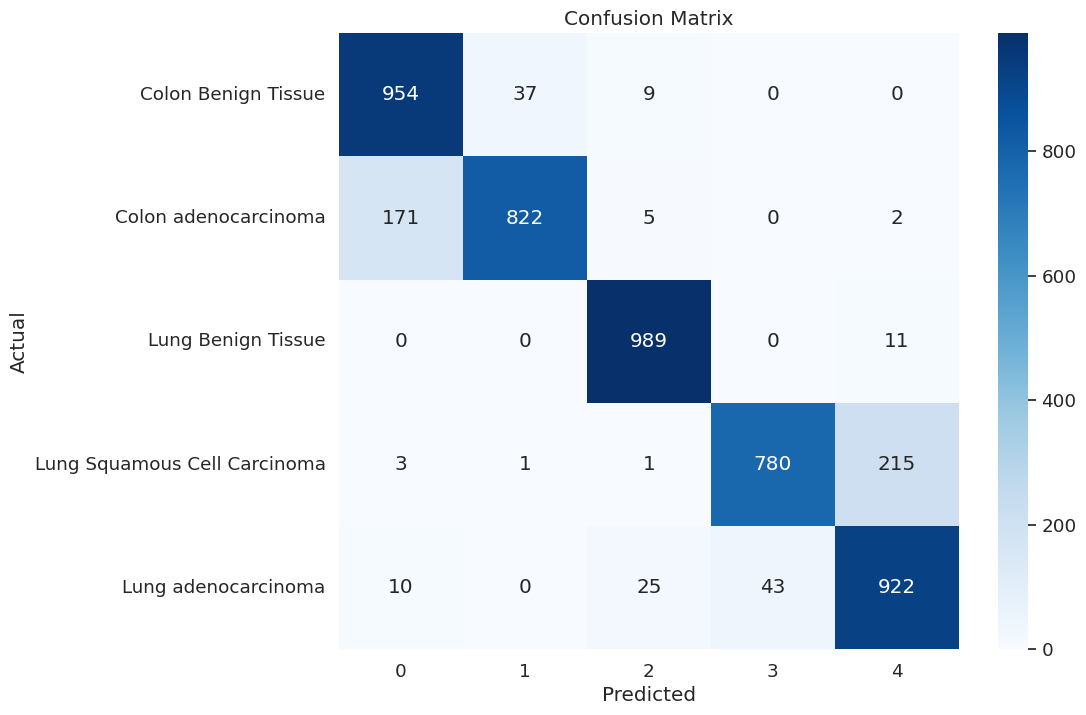

accuracy 0.8934
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1000
           1       0.96      0.82      0.88      1000
           2       0.96      0.99      0.97      1000
           3       0.95      0.78      0.86      1000
           4       0.80      0.92      0.86      1000

   micro avg       0.90      0.89      0.89      5000
   macro avg       0.90      0.89      0.89      5000
weighted avg       0.90      0.89      0.89      5000
 samples avg       0.89      0.89      0.89      5000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
confmatrix_and_classreport(X_test,y_test,classname,model)

# Transfer Learning Model (VGG16)


In [21]:
# Load a transfer learning model
vgg_model = VGG16(include_top=False, input_shape= X_train.shape[1:])

# Mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False
    
vgg_model.summary()
# Reference: transfer lerning model comes from the notebooks - practical 2


58889256/58889256 [==============================] - 0s 0us/step

Model: "vgg16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         

                                                                 

 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         

                                                                 

 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    

                                             

In [26]:
# Create a sequential model
model = Sequential()

# Add transfer learning model, flatten, and dense layers
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 2, 2, 512)         14714688  

                                                                 

 flatten_2 (Flatten)         (None, 2048)              0         

                                                                 

 dense_6 (Dense)             (None, 4096)              8392704   

                                                                 

 dense_7 (Dense)             (None, 4096)              16781312  

                                                                 

 dense_8 (Dense)             (None, 5)                 20485     

                                                                 


Total params: 39909189 (152.24 MB)

Trainable params: 25194501 (96.11 MB)

Non-trainable params: 14714688 (56.13 MB)

_____________________________________________________

In [27]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20

469/469 [==============================] - 13s 26ms/step - loss: 2.3593 - accuracy: 0.8919 - val_loss: 0.1809 - val_accuracy: 0.9324

Epoch 2/20

469/469 [==============================] - 12s 25ms/step - loss: 0.1587 - accuracy: 0.9409 - val_loss: 0.2071 - val_accuracy: 0.9318

Epoch 3/20

469/469 [==============================] - 12s 25ms/step - loss: 0.1338 - accuracy: 0.9510 - val_loss: 0.1871 - val_accuracy: 0.9382

Epoch 4/20

469/469 [==============================] - 12s 25ms/step - loss: 0.1042 - accuracy: 0.9607 - val_loss: 0.1545 - val_accuracy: 0.9498

Epoch 5/20

469/469 [==============================] - 12s 25ms/step - loss: 0.1019 - accuracy: 0.9643 - val_loss: 0.1600 - val_accuracy: 0.9524

Epoch 6/20

469/469 [==============================] - 12s 25ms/step - loss: 0.1006 - accuracy: 0.9651 - val_loss: 0.2453 - val_accuracy: 0.9320

Epoch 7/20

469/469 [==============================] - 12s 25ms/step - loss: 0.0800 - accuracy: 0.9685 - val_loss: 0.1476 - 

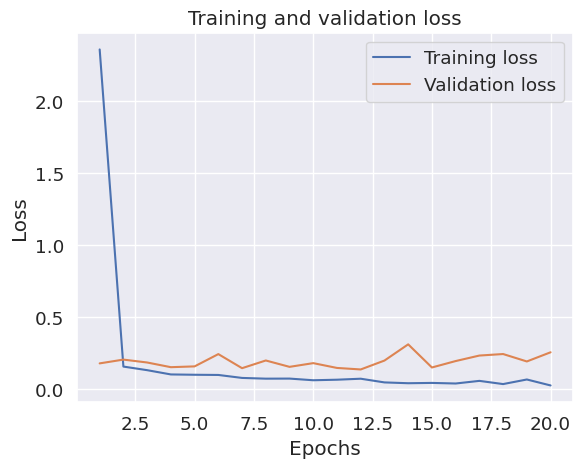

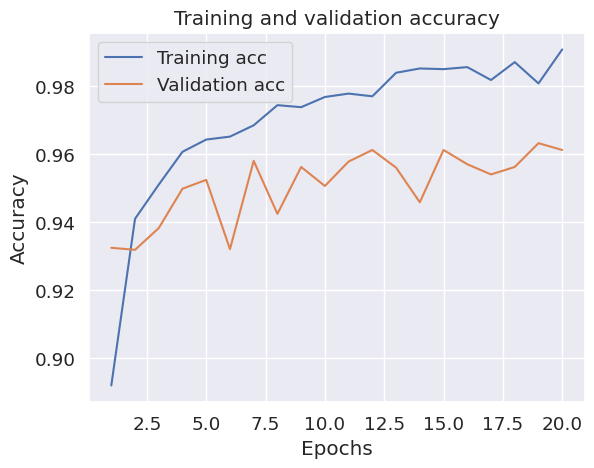

In [28]:
loss_and_accuracy_summary(history)

In [29]:
# Early stop is used here to find the optimal point
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/12

469/469 [==============================] - 12s 26ms/step - loss: 0.0301 - accuracy: 0.9905 - val_loss: 0.2536 - val_accuracy: 0.9620

Epoch 2/12

469/469 [==============================] - 12s 25ms/step - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.2325 - val_accuracy: 0.9598

Epoch 3/12

469/469 [==============================] - 12s 25ms/step - loss: 0.0319 - accuracy: 0.9901 - val_loss: 0.2784 - val_accuracy: 0.9576

Epoch 4/12

469/469 [==============================] - 12s 25ms/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.2694 - val_accuracy: 0.9612

Epoch 5/12

469/469 [==============================] - 12s 25ms/step - loss: 0.0295 - accuracy: 0.9913 - val_loss: 0.2823 - val_accuracy: 0.9592

Epoch 6/12

469/469 [==============================] - 12s 25ms/step - loss: 0.0294 - accuracy: 0.9901 - val_loss: 0.2650 - val_accuracy: 0.9594

Epoch 7/12

469/469 [==============================] - 12s 25ms/step - loss: 0.0880 - accuracy: 0.9817 - val_loss: 0.2219 - 

157/157 [==============================] - 2s 14ms/step


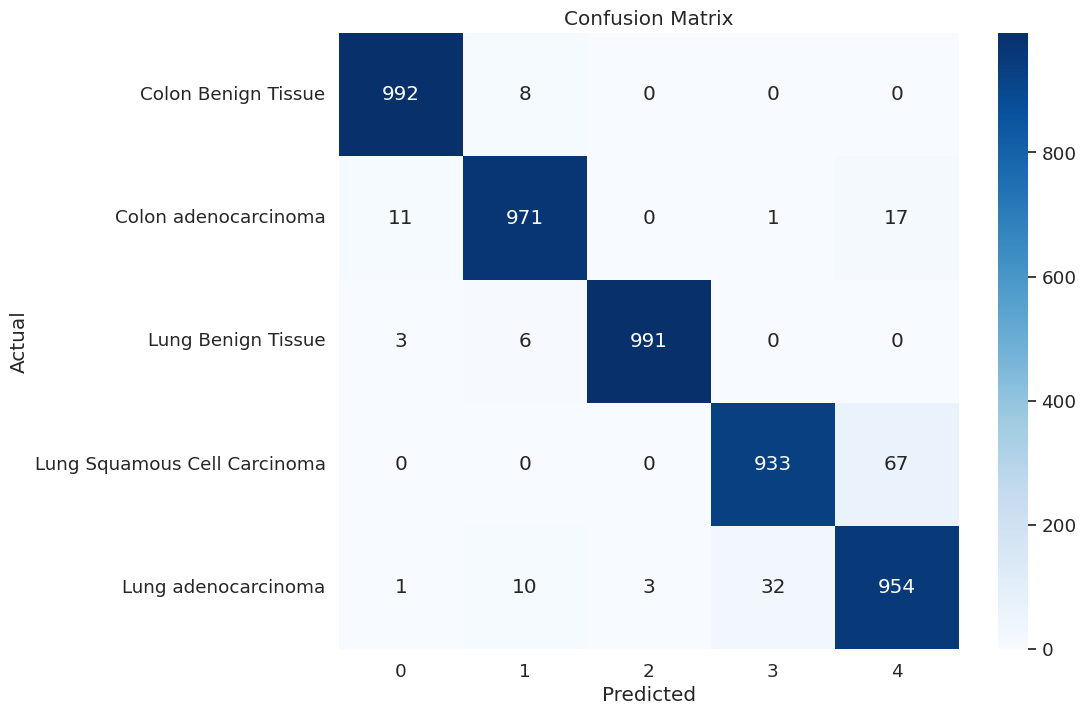

accuracy 0.9682

              precision    recall  f1-score   support



           0       0.99      0.99      0.99      1000

           1       0.98      0.97      0.97      1000

           2       1.00      0.99      0.99      1000

           3       0.97      0.93      0.95      1000

           4       0.92      0.95      0.94      1000



   micro avg       0.97      0.97      0.97      5000

   macro avg       0.97      0.97      0.97      5000

weighted avg       0.97      0.97      0.97      5000

 samples avg       0.97      0.97      0.97      5000




In [30]:
confmatrix_and_classreport(X_test,y_test,classname,model)

157/157 [==============================] - 2s 14ms/step


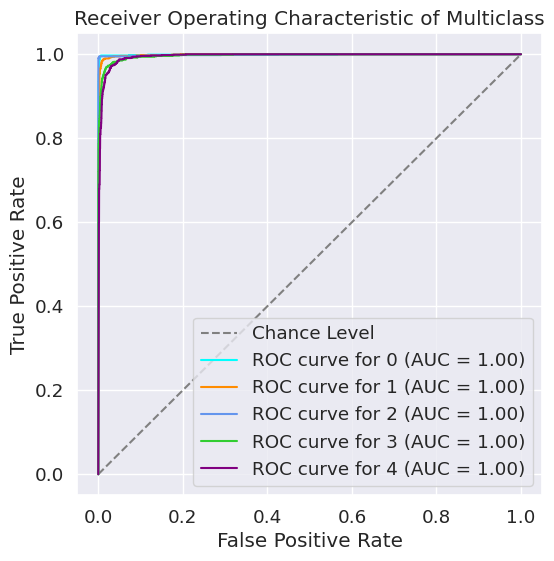

In [31]:
roc_curve(classname, X_test, y_test, model)